### Emotion Detect from Text using RNN

In [1]:
%pip -q install numpy
%pip -q install tensorflow
%pip -q install pandas
%pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt

import utils

In [3]:
# define path
train_csv = 'data/s3/training.csv'
test_csv = 'data/s3/test.csv'
val_csv = 'data/s3/validation.csv'

model_keras = 'models/t2e.keras'
model_saved = 'models/t2e'
model_tflite = 'models/t2e.tflite'

In [4]:
train_dataset = pd.read_csv(train_csv)
test_dataset = pd.read_csv(val_csv)

train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset['text'].values, train_dataset['label'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset['text'].values, test_dataset['label'].values))

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
BUFFER_SIZE = 5000
BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'im feeling a much more festive with the tree in'
 b'i don t even feel particularly loyal to shell'
 b'i havent written in awhile and it feels terrific to scribble stuff down in a notebook from time to time']

labels:  [1 2 1]


### Create the text encoder

The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the TextVectorization layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's .adapt method:

In [7]:
VOCAB_SIZE = 2000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'feel', 'and', 'to', 'the', 'a', 'that',
       'feeling', 'of', 'my', 'in', 'it', 'like', 'so', 'for', 'im', 'me',
       'but'], dtype='<U13')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  17,    9,    7,   86,   38,  651,   25,    6, 1257,   12,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,  104,   43,   75,    3,  372,  758,    5,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,  420, 1099,   12, 1984,    4,   13,  123,  817,    5,    1,
         394,  142,   12,    7,    1,   60,   52,    5,   52,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'im feeling a much more festive with the tree in'
Round-trip:  im feeling a much more festive with the tree in                                             

Original:  b'i don t even feel particularly loyal to shell'
Round-trip:  i don t even feel particularly loyal to [UNK]                                              

Original:  b'i havent written in awhile and it feels terrific to scribble stuff down in a notebook from time to time'
Round-trip:  i havent written in awhile and it feels terrific to [UNK] stuff down in a [UNK] from time to time                                   



In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True,
        ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [23]:
print([layer.supports_masking for layer in model.layers])
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

# predict on a sample text with padding
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[False, True, True, False, True, True, True]
1/1 [==============================] - 2s 2s/step
[0.16670202 0.16917095 0.16266051 0.17042126 0.1652473  0.16579793]
1/1 [==============================] - 0s 87ms/step
[0.1667112  0.16916382 0.16266185 0.17041491 0.16525505 0.16579312]


In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          128000    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                      

In [25]:
# Extract text and labels
train2 = pd.read_csv(train_csv)
text_data = train2['text']
labels = train2['label']

# Use LabelEncoder to convert integer labels to categorical labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert categorical labels to one-hot encoded vectors
one_hot_labels = to_categorical(encoded_labels)

In [26]:
# model.fit(train_dataset, epochs=4,
#                     validation_data=test_dataset,
#                     validation_steps=30)
history = model.fit(text_data, one_hot_labels, epochs=10, validation_split=0.2)

Epoch 1/10
400/400 [==============================] - 15s 21ms/step - loss: 1.2238 - accuracy: 0.5100 - val_loss: 0.5992 - val_accuracy: 0.8344
Epoch 2/10
400/400 [==============================] - 6s 16ms/step - loss: 0.4244 - accuracy: 0.8546 - val_loss: 0.2719 - val_accuracy: 0.9031
Epoch 3/10
400/400 [==============================] - 6s 16ms/step - loss: 0.2337 - accuracy: 0.9196 - val_loss: 0.2406 - val_accuracy: 0.9109
Epoch 4/10
400/400 [==============================] - 6s 16ms/step - loss: 0.1783 - accuracy: 0.9352 - val_loss: 0.2401 - val_accuracy: 0.9203
Epoch 5/10
400/400 [==============================] - 6s 16ms/step - loss: 0.1421 - accuracy: 0.9489 - val_loss: 0.2554 - val_accuracy: 0.9166
Epoch 6/10
400/400 [==============================] - 6s 16ms/step - loss: 0.1226 - accuracy: 0.9592 - val_loss: 0.2415 - val_accuracy: 0.9206
Epoch 7/10
400/400 [==============================] - 6s 15ms/step - loss: 0.1087 - accuracy: 0.9597 - val_loss: 0.2440 - val_accuracy: 0.915

In [69]:
sample_text = ("i pay attention it deepens into a feeling of being invaded and helpless")
predictions = model.predict(np.array([sample_text]))

predictions = [float("{:.4f}".format(n)) for n in predictions.tolist()[0]]

predictions

1/1 [==============================] - 0s 23ms/step


[0.4634, 0.0003, 0.0, 0.0088, 0.5275, 0.0001]

In [72]:
top_two_indices = np.argsort(predictions)[-2:]

# Get the corresponding label names
top_two_labels = [labels[i] for i in top_two_indices]

top_two_labels

['sadness', 'fear']

(0.0, 1.2816234182566404)

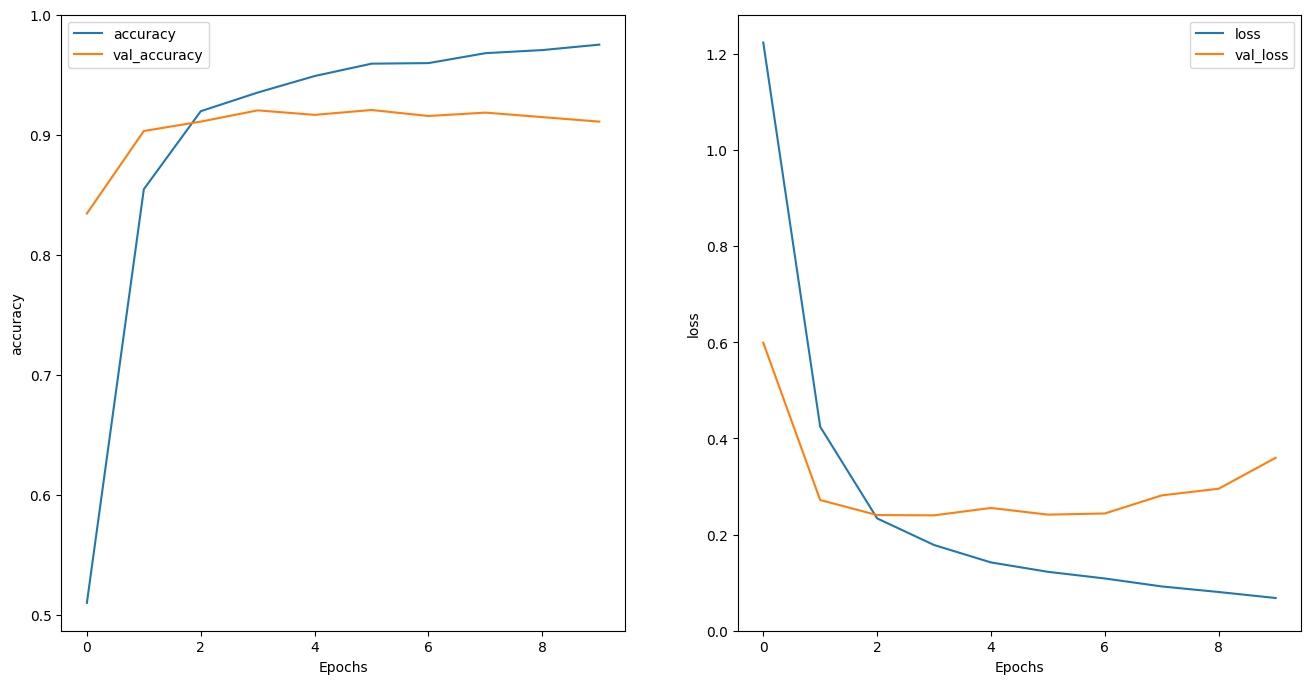

In [59]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
utils.plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
utils.plot_graphs(history, 'loss')
plt.ylim(0, None)